# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_500", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata.head(30)

,timestamp,sqrtPriceX96,price,datetime
0,1620608620,1267390127144248068978361798426155,0.000256,2021-05-10 01:03:40
1,1620608625,1267680042870333742156839070397317,0.000256,2021-05-10 01:03:45
2,1620608735,1267817457383972330861871773689515,0.000256,2021-05-10 01:05:35
3,1620609459,1267594782604196631584143944219246,0.000256,2021-05-10 01:17:39
4,1620609550,1268216030588665931252309527014595,0.000256,2021-05-10 01:19:10
5,1620609686,1267993215791331786083713982158137,0.000256,2021-05-10 01:21:26
6,1620609733,1264263863208224434398878067428678,0.000255,2021-05-10 01:22:13
7,1620609758,1265642978878366055891444092911643,0.000255,2021-05-10 01:22:38
8,1620609758,1265767228475259915825077209470712,0.000255,2021-05-10 01:22:38
9,1620609987,1266751956268810044386866762478026,0.000256,2021-05-10 01:26:27


In [2]:
pricedata['SmaLowerLma'] = [np.nan]*len(pricedata)
pricedata['VolLowerBelowmaQuantile50'] = [np.nan]*len(pricedata)
pricedata['CloseLowerMA'] = [np.nan]*len(pricedata)
pricedata['VolHigherOvermaQuantile50Twosigma'] = [np.nan]*len(pricedata)
pricedata['revoke_pos'] = [np.nan]*len(pricedata)

# 指标计算

In [3]:
pricedata_res = pricedata[['timestamp','sqrtPriceX96','price',
                           'SmaLowerLma',
                           'VolLowerBelowmaQuantile50',
                          'CloseLowerMA',
                           'VolHigherOvermaQuantile50Twosigma',
                           'revoke_pos']]
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
0,1620608620,1267390127144248068978361798426155,0.000256,NaN,NaN,NaN,NaN,NaN
1,1620608625,1267680042870333742156839070397317,0.000256,NaN,NaN,NaN,NaN,NaN
2,1620608735,1267817457383972330861871773689515,0.000256,NaN,NaN,NaN,NaN,NaN
3,1620609459,1267594782604196631584143944219246,0.000256,NaN,NaN,NaN,NaN,NaN
4,1620609550,1268216030588665931252309527014595,0.000256,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
829000,1636441571,1142082588585671647785500155330124,0.000208,NaN,NaN,NaN,NaN,NaN
829001,1636441571,1142071759175866417828744621024494,0.000208,NaN,NaN,NaN,NaN,NaN
829002,1636441612,1142000969568059491037541876247525,0.000208,NaN,NaN,NaN,NaN,NaN
829003,1636441612,1142013920888200672190989935421715,0.000208,NaN,NaN,NaN,NaN,NaN


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.00025589480656772624


# 建池撤池详细信息

In [5]:
import Strategy_none_500_50per
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_none_500_50per)
strategy = Strategy_none_500_50per.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Below MA】【创建Short Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  349675000000.0 amount1:  157752711032827412480
price:  0.00025589480656772624
$$$$$$$【Upper Price】: 0.00038384220985158935
$$$$$$$【Lower Price】: 0.00012794740328386312
######【L】:30665171017896772【USDC】:349675000000【ETH】:144022982878637948928
将要投入池子的数量 amount_t0: 349674999999 amount_t1: 144022982878637948928
【RealWorldTime】:2021-05-10 09:03:40, Timestamp: 1620608620, Blocknumber: 12403549
Mint position： Position(L=30662821116099108, tick=[186660, 197640], range=[2612.3599, 7831.8525])
【Mint amount】: token0=349605.073572, token1=144.02298287863795
Wallet amount: token0=69.926428, token1=13.729728154189463


# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x1dd18d036d8>}

In [7]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

In [8]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

<AxesSubplot:>

In [9]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620608620,616474.844288
1620608625,616631.395138
1620608735,616705.524709
1620609459,616585.545560
1620609550,616920.443380
...,...
1636441469,502862.001554
1636441482,502859.493791
1636441498,502848.446729


In [10]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620608620,349675.000000
1620608625,349236.627306
1620608735,349028.917062
1620609459,349365.694234
1620609550,348426.872783
...,...
1636441469,605217.894142
1636441482,605229.659070
1636441498,605243.629698


In [11]:
tb_Timing

2021-05-10 09:03:40    9.661498e+05
2021-05-10 09:03:45    9.658680e+05
2021-05-10 09:05:35    9.657344e+05
2021-05-10 09:17:39    9.659512e+05
2021-05-10 09:19:10    9.653473e+05
                           ...     
2021-11-09 15:04:29    1.108080e+06
2021-11-09 15:04:42    1.108089e+06
2021-11-09 15:04:58    1.108092e+06
2021-11-09 15:06:11    1.108102e+06
2021-11-09 15:06:52    1.108174e+06
Length: 509255, dtype: float64

# 计算绩效指标

In [12]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.005414e+06
2021-05-11    9.843797e+05
2021-05-12    1.012977e+06
2021-05-13    9.454705e+05
2021-05-14    1.001952e+06
                  ...     
2021-11-05    1.068425e+06
2021-11-06    1.060572e+06
2021-11-07    1.085237e+06
2021-11-08    1.103341e+06
2021-11-09    1.108174e+06
Freq: D, Length: 184, dtype: float64

In [13]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.005414e+06,NaN,NaN
2021-05-11,9.843797e+05,-0.020921,-0.020921
2021-05-12,1.012977e+06,0.029052,0.029052
2021-05-13,9.454705e+05,-0.066642,-0.066642
2021-05-14,1.001952e+06,0.059740,0.059740
...,...,...,...
2021-11-04,1.070399e+06,-0.005821,-0.005821
2021-11-05,1.068425e+06,-0.001844,-0.001844
2021-11-06,1.060572e+06,-0.007350,-0.007350
2021-11-07,1.085237e+06,0.023256,0.023256


<AxesSubplot:>

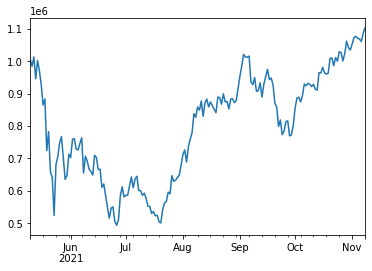

In [14]:
df_tb['close'].plot()

In [15]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


【SWAP_USDC_WETH_3000】

USDC手续费 24905.579442 ETH手续费(USDC计价) 33621.28031400637
***************************资金曲线绩效***************************
最大回撤 0.5127388570671596
最长回撤持续期 113 日 起始日期 2021-05-12 00:00:00 结束日期 2021-09-02 00:00:00
年化收益 0.20490032648956236
夏普比率 0.20723248258744634
卡尔玛比率 0.3996192675187168


<AxesSubplot:title={'center':'Total Balance'}>

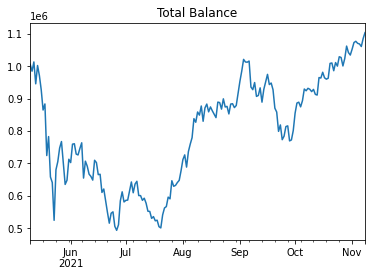

In [16]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')